## Goal:

Here we test the functions: `lbfgsb` in the `Screenkhorn` class.

In [1]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/code'
sys.path.insert(0, path_files) 


# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

# SCREENKHORN
from new_formulation import Screenkhorn


## Data generation

In [2]:
n_1 = 10000# nb samples
n_2 = 10000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# a = abs(np.random.normal(size=(n_1,)))
# b = abs(np.random.normal(size=(n_2,)))
# a = a / a.sum()
# b = b / b.sum()

# loss matrix
C = ot.dist(xs, xt)
C /= C.max()

lower_bound_epsilon = C.max()/806
eta = lower_bound_epsilon
eta = 1e1
# lower_bound_epsilon = 0.0012406947890818859

In [3]:
xt.shape

(10000, 2)

In [4]:
Pemd = emd(a, b, C, numItermax=100000, log=False)

/Users/mzalaya/anaconda3/lib/python3.6/site-packages/ot/lp/__init__.py:104: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


## Sinkhorn 

In [5]:
tic = time()
eta_sink = 1e-1
P_sink = sinkhorn(a, b, C, eta_sink, log=True)
time_sink = time() - tic
Pstar = P_sink[0]
outputs_dict = P_sink[1]
ustar = outputs_dict['u']
vstar = outputs_dict['v']
time_sink

2.888134002685547

## L-BFGS-B

In [6]:
tic = time()
screenkhorn = Screenkhorn(a, b, C, eta, n_b=100, m_b=100)
lbfgsb = screenkhorn.lbfgsb()
time_bfgs = time() - tic
usc = lbfgsb[0]
vsc = lbfgsb[1]
Psc = lbfgsb[2]

|I_active| = 100 	 |J_active| = 100 	 |I_active| + |J_active| = 200



In [7]:
screenkhorn.epsilon, screenkhorn.fact_scale

(0.0001021394074195899, 0.9941098426082919)

In [8]:
screenkhorn.epsilon / screenkhorn.fact_scale, screenkhorn.epsilon * screenkhorn.fact_scale

(0.00010274458922124946, 0.00010153779023399273)

In [9]:
# print(screenkhorn.bounds_u[:10])
# print('\n')
# print(screenkhorn.bounds_v[:10])

## Time comparison between Sinkhorn and L-BFGS-B

In [10]:
print('\n')
print("Time of the LBFGS initialization is %s \n" %screenkhorn.toc_initial)
print("Time of Sinkhorn: %s" %time_sink, '\n')
print("Ratio Time: Sinkhorn / class initialization: %s \n" %(time_sink / screenkhorn.toc_initial))
print("Time of LBFGS inculding the class initialization: %s\n" %time_bfgs)
print("Ratio Time: Sinkhorn / LBFGS: %s \n" %(time_sink / time_bfgs))
print("Ratio Time: LBFGS / Sinkhorn : %s" %(time_bfgs / time_sink))



Time of the LBFGS initialization is 0.7390789985656738 

Time of Sinkhorn: 2.888134002685547 

Ratio Time: Sinkhorn / class initialization: 3.9077473562238016 

Time of LBFGS inculding the class initialization: 1.6192917823791504

Ratio Time: Sinkhorn / LBFGS: 1.7835784965462773 

Ratio Time: LBFGS / Sinkhorn : 0.5606705855315035


## Some plots

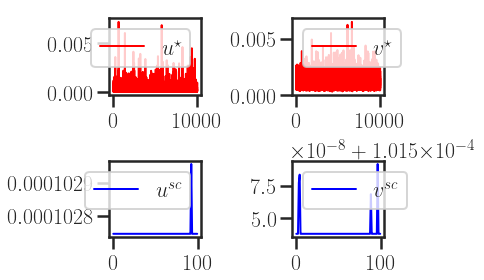

In [11]:
figure, axes= plt.subplots(nrows=2, ncols=2)

axes[0,0].plot(ustar, linewidth=2, color='r', label=r'$u^{\star}$')
axes[0,1].plot(vstar, linewidth=2, color='r', label=r'$v^{\star}$')
axes[0,0].legend()
axes[0,1].legend();

axes[1,0].plot(usc[:100], linewidth=2, color='b', label=r'$u^{sc}$')
axes[1,1].plot(vsc[:100], linewidth=2, color='b', label=r'$v^{sc}$')
axes[1,0].legend()
axes[1,1].legend()
# axes[0,0].set_title("log scale")
# axes[0,1].set_title("log scale")
axes[0,0].legend();
plt.subplots_adjust(hspace=.5)
plt.tight_layout()

In [12]:
# Gradient w.r.t. u
# plt.plot(lbfgsb[3]['grad'][:len(screenkhorn.I)]);

In [13]:
Jusc = np.where(vsc > screenkhorn.epsilon * screenkhorn.fact_scale)[0].tolist()
print(len(Jusc))

97


In [14]:
print(len(screenkhorn.I))

100


In [15]:
# Gradient w.r.t. v
# plt.plot(lbfgsb[3]['grad'][len(screenkhorn.I):]); 

In [16]:
## sinkhorn
astar = Pstar @ np.ones(n_2)
bstar = Pstar.T @ np.ones(n_1)
# screenkhorn via lbfgsb
asc = Psc @ np.ones(n_2)
bsc = Psc.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(astar), sum(bstar)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(asc), sum(bsc)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(astar)), abs(1 - sum(bstar))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(asc)), abs(1 - sum(bsc))))
print("\t")

print("Frobenius norm of difference solution matrices %s " %np.linalg.norm(Pstar - Psc,'fro'))

sum of the marginals in sinkhorn are: 0.9999999999999062, 	 0.9999999999999061
	
sum of the marginals in screenkhorn are: 1.0166771026179873, 	 1.0166771026179855
	
Difference in sinkhorn: 9.381384558082573e-14 	 9.392486788328824e-14:
	
Difference in screenkhorn: 0.01667710261798727 	  0.016677102617985495:
	
Frobenius norm of difference solution matrices 1.9767888258796973e-05 


0.00010385393805578304 1.0166771026179886


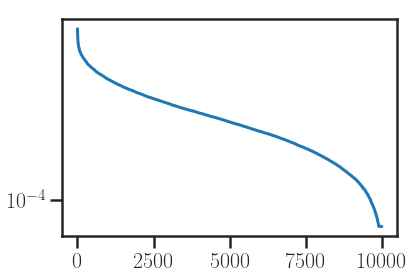

In [17]:
plt.semilogy(np.sort(asc)[::-1]); print(np.sort(asc)[::-1][0], np.sort(asc)[::-1].sum())

0.00010295100395325465 1.0166771026179886


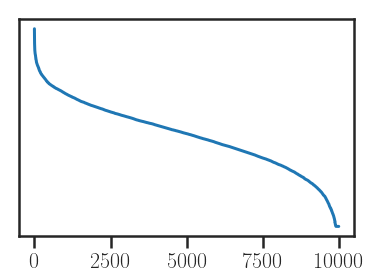

In [18]:
plt.semilogy(np.sort(bsc)[::-1]); print(np.sort(bsc)[::-1][0], np.sort(bsc)[::-1].sum())

In [19]:
np.argmax(asc), np.argmax(bsc)

(3247, 4273)

In [20]:
usc[717]

0.00010274458922124946

In [21]:
Iusc = np.where(usc > screenkhorn.epsilon / screenkhorn.fact_scale)[0].tolist()
# print(Iusc)

In [22]:
# print(screenkhorn.I)

In [23]:
Jusc = np.where(vsc > screenkhorn.epsilon * screenkhorn.fact_scale)[0].tolist()
# print(Jusc)

In [24]:
# print(screenkhorn.J)

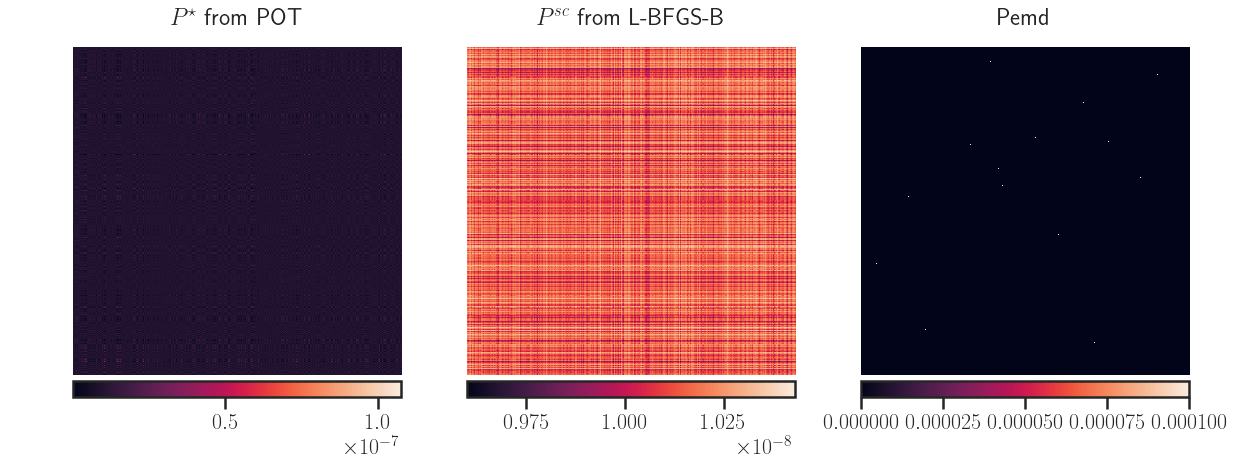

In [25]:
cb_padding = 0.005
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
I1 = ax1.matshow(Pstar)
ax1.set_title(r'$P^\star$ from POT')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(Psc)
ax2.set_title(r'$P^{sc}$ from L-BFGS-B');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
I3 = ax3.matshow(Pemd)
ax3.set_title('Pemd');
ax3.label_outer()
ax3.axis('off');
fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)

In [26]:
np.multiply(Pstar, C).sum(), np.multiply(Psc, C).sum(), np.multiply(Pemd, C).sum()

(0.2551388289133377, 0.2624913251129016, 0.23453453671482208)

In [27]:
# raise "Error"

In [28]:
I = screenkhorn.I
J= screenkhorn.J
epsilon = screenkhorn.epsilon
fact_scale = screenkhorn.fact_scale
I_usc = np.where(usc > epsilon / fact_scale)[0].tolist()
J_usc = np.where(vsc > epsilon*fact_scale)[0].tolist()

In [29]:
print(len(I_usc), len(I))

99 100


In [30]:
print(len(J_usc), len(J))

97 100


In [31]:
# print(I[:100], '\n')
# print(I_usc[:100], '\n')

## Time comparison regarding regularization parameter

In [32]:
# etas = np.linspace(0.0007, 0.001, 100)
# times_sink = []
# times_screen = []
# ot_costs_sink = []
# ot_costs_screen = []
# for eta in etas:
#     # time for sinkhorn
#     tic = time()
#     P_sink = sinkhorn(a, b, C, eta, log=True)
#     time_sink = time() - tic
#     times_sink.append(time_sink)
#     # time for screenkhorn
#     tic = time()
#     screenkhorn = Screenkhorn(a, b, C, eta, N=n_1, M=n_2)
#     lbfgsb = screenkhorn.lbfgsb()
#     time_screen = time() - tic
#     times_screen.append(time_screen)
#     # cost of ot
#     ot_costs_sink.append(np.multiply(Pstar, C).sum())
#     ot_costs_screen.append(np.multiply(Psc, C).sum())

In [33]:
# times_sink = np.asarray(times_sink)
# times_screen = np.asarray(times_screen)
# plt.plot(etas, times_sink, label='sinkhorn')
# plt.plot(etas, times_screen, label='screenkhorn')
# plt.title(r"Time comparison for $n=m=1000$ and $N=M=1000$")
# plt.ylabel("Time (seconds)")
# plt.xlabel(r'$\eta$: regularization parameter')
# plt.legend();

In [34]:
# plt.plot(etas, ot_costs_sink)
# plt.plot(etas, ot_costs_screen);